# Fragments

> fragment related functions

In [ ]:
#| default_exp fragment

In [ ]:
#| hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from chem_templates.imports import *
from chem_templates.utils import *
from chem_templates.chem import Molecule, canon_smile, to_mol, to_smile
from rdkit import Chem
from rdkit.Chem import rdMMPA

In [ ]:
#| export

def remove_fragment_mapping(smile: str) -> str:
    patt = re.compile('\[\*(.*?)]')
    smile = patt.sub('[*]', smile)
    return canon_smile(smile)

def is_mapped(smile: str) -> bool:
    patt = re.compile('\[\*(.*?)]')
    return len(patt.findall(smile)) == smile.count('*')

def remove_fragment_dummies(smile: str) -> str:
    smile = remove_fragment_mapping(smile)
    smile = canon_smile(smile.replace('*', '[H]'))
    return smile

def add_fragment_mapping(smile:    str, 
                         map_nums: list[int]) -> str:
    
    assert smile.count('*') == len(map_nums)
    
    smile = remove_fragment_mapping(smile)
    
    new_smile = ''
    map_idx = 0
    for char in smile:
        if char=='*':
            new_smile += f'[*:{map_nums[map_idx]}]'
            map_idx += 1
        else:
            new_smile += char
            
    return new_smile

def generate_mapping_permutations(smile:    str, 
                                  map_nums: list[int], 
                                  exact:    bool=False) -> list[str]:
    
    n_attachments = smile.count('*')
    
    if map_nums is None:
        map_nums = list(range(1, n_attachments+1))
    
    if exact:
        assert n_attachments == len(map_nums)
    else:
        assert n_attachments <= len(map_nums)
    
    perms = permutations(map_nums, n_attachments)
    outputs = []
    for p in perms:
        outputs.append(add_fragment_mapping(smile, p))
        
    return outputs

In [ ]:
assert is_mapped('CNCC')
assert is_mapped('[*:1]C[*:1]')
assert not is_mapped('[*:1]C*')
assert not is_mapped('*C*')
assert remove_fragment_mapping('[*:1]C[*:2]') == '*C*'
assert add_fragment_mapping('*C*', [3,4]) == '[*:3]C[*:4]'
assert generate_mapping_permutations('*C*', [4,5]) == ['[*:4]C[*:5]', '[*:5]C[*:4]']

In [ ]:
#| export

def fragment_mol(mol: Chem.Mol, 
                 cuts: list[int]) -> list[str]:
    fragments = []
    for cut in cuts:
        frags = rdMMPA.FragmentMol(mol, maxCuts=cut, resultsAsMols=False)
        frags = deduplicate_list(flatten_list(frags))
        fragments += frags
        
    fragments = deduplicate_list(fragments)
    return fragments

def clean_fragments(fragments: list[str], 
                    remove_mapping: bool=True) -> list[str]:
    patt = re.compile('\[\*(.*?)]')
    clean_fragments = []
    fragments = list(fragments)
    
    while fragments:
        current = fragments.pop()
        
        if not current:
            continue
            
        if '.' in current:
            fragments += current.split('.')
        else:
            if remove_mapping:
                current = remove_fragment_mapping(current)
                
            current = canon_smile(current)
            if current:
                clean_fragments.append(current)
                
    clean_fragments = deduplicate_list(clean_fragments)
    return clean_fragments


def fragment_smile(smile: str, 
                   cuts: list[int],
                   remove_mapping: bool=True
                  ) -> list[str]:
    
    mol = to_mol(smile)
    if mol is not None:
        fragments = fragment_mol(mol, cuts)
        clean = clean_fragments(fragments, remove_mapping=remove_mapping)
    else:
        clean = []

    return clean

def fragment_molecule(molecule: Molecule,
                      cuts: list[int],
                      remove_mapping: bool=True
                     ) -> list[Molecule]:
    
    fragments = fragment_mol(molecule.mol, cuts)
    clean = clean_fragments(fragments, remove_mapping=remove_mapping)
    clean = [Molecule(i) for i in clean]

    return clean

In [ ]:
smile = 'C=CC(=O)Nc1cc(Nc2nccc(Nc3ccccc3P(C)(C)=O)n2)c(OC)cc1N(C)CCN(C)C'
frags = fragment_smile(smile, [1,2], remove_mapping=True)
assert len(frags) == 146

molecule = Molecule(smile)
frags = fragment_molecule(molecule, [1,2])
assert len(frags) == 146

In [ ]:
#| export

def fuse_mol_on_atom_mapping(mol: Chem.Mol) -> Union[Chem.Mol, None]:
    try:
        return Chem.molzip(mol)
    except:
        return None
    
def fuse_smile_on_atom_mapping(smile: str) -> str:
    mol = to_mol(smile)
    mol = fuse_mol_on_atom_mapping(mol)
    if mol is not None:
        return to_smile(mol)
    else:
        return ''

In [ ]:
f1 = '[*:1]CC'
f2 = '[*:1]CNC'
f3 = '[*:2]CNC'
f4 = '*CNC'
assert fuse_smile_on_atom_mapping(f1 + '.' + f2) == 'CCCNC'
assert fuse_smile_on_atom_mapping(f1 + '.' + f3) == 'CC[*:1].CNC[*:2]'
assert fuse_smile_on_atom_mapping(f1 + '.' + f4) == '*CNC.CC[*:1]'

In [ ]:
#| export

def get_dummy_mol(name:     str, 
                  map_nums: list[int],
                  id:       Optional[int]=None
                 ) -> Chem.Mol:
    templates = {
        0 : '[Zr]',
        1 : '[*][Zr]',
        2 : '[*][Zr][*]',
        3 : '[*][Zr]([*])[*]',
        4 : '[*][Zr]([*])([*])[*]'
    }
    
    num_attachments = len(map_nums)
    mapping_idx = 0
    template = templates[num_attachments]
    template = add_fragment_mapping(template, map_nums)
    
    if id is not None:
        template = template.replace('Zr', f'Zr:{id}')
            
    mol = to_mol(template)
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() != 0:
            atom.SetProp('atomLabel', name)
            
    return mol

def combine_dummies(dummies: list[Chem.Mol], 
                    fuse:    bool=True) -> Chem.Mol:
    combo = Chem.MolFromSmiles('')
    for mol in dummies:
        combo = Chem.CombineMols(combo, mol)
        
    if fuse:
        combo = Chem.molzip(combo)
        
    return combo

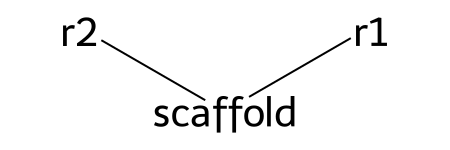

In [ ]:
assert to_smile(get_dummy_mol('r1', [3,4,5])) == '[Zr]([*:3])([*:4])[*:5]'

scaffold = get_dummy_mol('scaffold', [1,2])
r1 = get_dummy_mol('r1', [1])
r2 = get_dummy_mol('r2', [2])
fused = combine_dummies([scaffold, r1, r2])
assert to_smile(fused) == '[Zr][Zr][Zr]'
fused

In [ ]:
#| export

def flatten_fragments(batch: dict[str, list]) -> dict:
    return {'fragments': flatten_list(batch['fragments'])}

def regen_smiles(batch: dict[str, list], 
                 max_fragment_length: int) -> dict:
    outputs = []
    for fragment in batch['fragments']:
        if len(fragment) > max_fragment_length:
            outputs.append(remove_fragment_dummies(fragment))
            
    return {'smiles' : outputs}


def shred_smiles(smiles:              list[str], 
                 cuts:                list[int], 
                 max_fragment_length: int, 
                 generations:         int, 
                 keep_long_fragments: bool, 
                 num_proc:            int=1) -> list[str]:
    
    start = time.time()
    outputs = []
    
    for g in range(generations):
        print(f'processing {len(smiles)} smiles')
        smiles_dataset = datasets.Dataset.from_dict({'smiles' : smiles})
        
        smiles_dataset = smiles_dataset.map(lambda row: {'fragments' : fragment_smile(row['smiles'], cuts)},
                                   num_proc=num_proc)
        
        fragment_dataset = smiles_dataset.map(lambda row: flatten_fragments(row), remove_columns='smiles', 
                                      batched=True, num_proc=num_proc)
        
        smiles_dataset = fragment_dataset.map(lambda row: regen_smiles(row, max_fragment_length),
                                     remove_columns='fragments', batched=True, num_proc=num_proc)
        
        if not keep_long_fragments:
            fragment_dataset = fragment_dataset.filter(lambda row: len(row['fragments'])<=max_fragment_length)
            
        outputs += fragment_dataset['fragments']
        smiles = deduplicate_list(smiles_dataset['smiles'])
        outputs = deduplicate_list(outputs)
        
        print(f'Generation {g}, {len(outputs)} fragments')
        
    duration = time.time() - start
    print(f'finished in {duration/60} minutes')
    return outputs

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()